In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime as dt
import time
import awkward as ak
import uproot
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

import re

In [39]:
import polars as pl
runscsv = sorted(glob(f"./runlists/*_runs.csv"))

dfs = [ pl.read_csv(f) for f in runscsv]

def get_efield(run):
    for df in dfs:

        dfo = df.filter(pl.col('Run')==run)
        if not dfo.is_empty():
            return dfo['Efield'].to_list()[0]
    print(f"Could not find for run {run}")
    return -1


(1200.0, 1600.0)

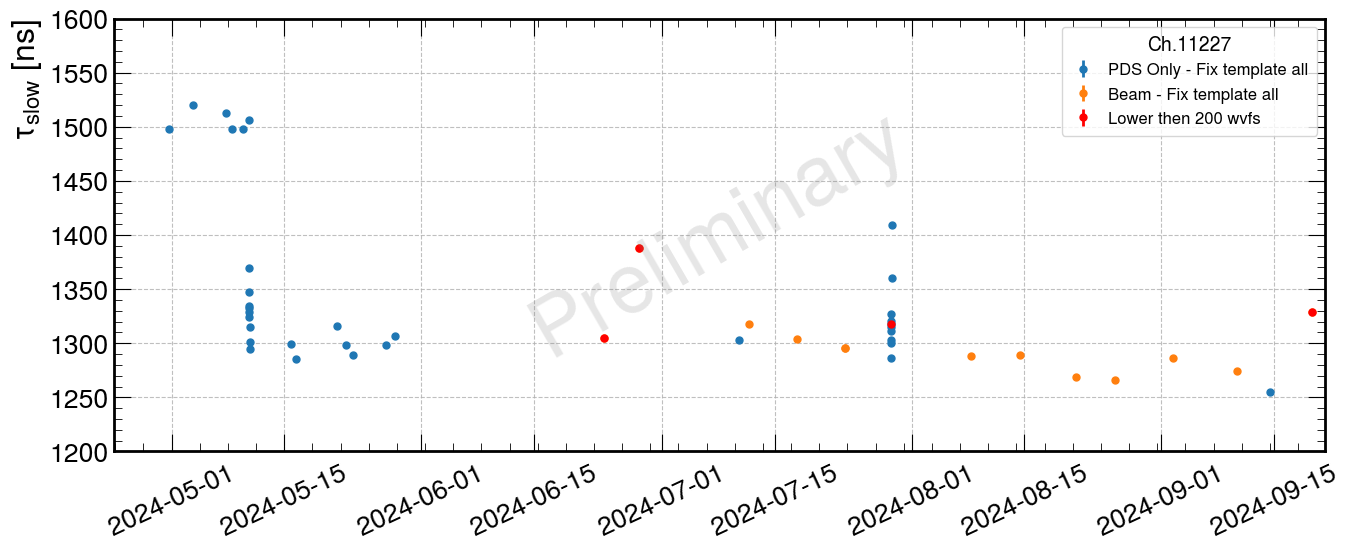

In [98]:
def selection(data):
    _data = data[data['nwvf']<200]
    return _data

def read_conv_data(folder = "./results_fixtemplate", ch = 11225):
    if folder.endswith("/"):
        folder = folder[:-1]
    files = sorted(glob(f"{folder}/run0*/convolution_output*.txt"))
    files = [ f for f in files if str(ch) in f]


    dtp = np.dtype([
        ("timestamp", np.uint64),
        ("A_f", np.float32),
        ("tau_f", np.float32 ),
        ("tau_s", np.float32 ),
        ("Efield", np.float32 ),
        ("run", np.int16 ),
        ("time", np.object_ ),
        ("chi2", np.float32 ),
        ("nwvf", np.int64 ),
    ])

    data = np.zeros(len(files), dtype=dtp)
    runs = []
    for i, file in enumerate(files):
        tmp = np.fromfile(file, sep=' ')
        p = re.compile('[0-9]+')
        runnumber = file.replace(f'{folder}/run0','')
        runnumber = (int(p.match(runnumber).group(0)))
        runs.append(runnumber)

        data[i]['timestamp'] = tmp[0]*16e-9
        data[i]['A_f'] = tmp[1]
        data[i]['tau_f'] = tmp[2]
        data[i]['tau_s'] = tmp[3]
        data[i]['run'] = runnumber
        data[i]['Efield'] = get_efield(runnumber)
        data[i]['time'] = dt.datetime.fromtimestamp(tmp[0]*16e-9)
        data[i]['chi2'] = tmp[4]
        data[i]['nwvf'] = tmp[5]


    return data

def preliminary(ax, x=0.5, y=0.5):
    ax.text(x, y, 'Preliminary', transform=ax.transAxes,
            fontsize=60, color='gray', alpha=0.2,
            ha='center', va='center', rotation=30)
def plot_vs_time(data,
                 x='time',
                 y='tau_s',
                 skipp = None,
                 endp = None,
                 label='',
                 showHours=False,
                 isTime=True,
                 loc='best',
                 xlim = None,
                 selection=None,
                 legfontsize=16,
                 legtitle='',
                 **kwargs):
        
    if selection:
        data = selection(data)
    if 'linewidth' not in kwargs.keys():
        kwargs['linewidth'] = 2
    if 'markersize' not in kwargs.keys():
        kwargs['markersize'] = 10
    if 'yerr' not in kwargs.keys():
        kwargs['yerr'] = 0
    if 'fmt' not in kwargs.keys():
        kwargs['fmt'] = '.'
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    if isTime:
        if showHours:
            xfmt = mdate.DateFormatter('%Y-%m-%d\n%H:%M')
        else:
            xfmt = mdate.DateFormatter('%Y-%m-%d')
        ax.xaxis.set_major_formatter(xfmt)
    plt.errorbar(data[x][skipp:endp], data[y][skipp:endp], label=label, **kwargs)
    plt.ylabel(r'$\tau_{slow}$ [ns]')
    plt.legend(title=legtitle,loc=loc,frameon=True, fontsize=legfontsize, title_fontsize=legfontsize+2)
    plt.xlim(xlim)
    
# data = read_conv_data("./results_fixtemplate/")
ch = 11227
data = read_conv_data("./results/", ch=ch)
datafix = read_conv_data("./results_fixtemplate/", ch=ch)
datafix2 = read_conv_data("./results_new_template_fixtemplate/", ch=ch)
datafixu = read_conv_data("./results_ultimate2_inter_fixtemplate/", ch=ch)
databeam = read_conv_data("./results_beam/", ch=ch)
databeamfix = read_conv_data("./results_beam_fixtemplate/", ch=ch)
databeamfix2 = read_conv_data("./results_beam_new_template_fixtemplate/", ch=ch)
databeamfixu = read_conv_data("./results_beam_ultimate2_inter_fixtemplate/", ch=ch)

xlim=(None,None)
# xlim = (dt.datetime(2024,7,29,10), dt.datetime(2024,7,29,12))
varplot = dict(
    x = 'time',
    y = 'tau_s',
    skipp=None,
    endp=None,
    showHours = False,
    legtitle=f"Ch.{ch}",
    legfontsize=12,
)
varplot_low_nwvf = varplot.copy()
varplot_low_nwvf.update(dict(
    selection=selection,
    color='r'
))
# plot_vs_time(data, label='PDS Only - Dynamic template', **varplot)
# plot_vs_time(datafix, label='PDS Only - Fix template 26261', **varplot)
# plot_vs_time(datafix2, label='PDS Only - Fix template 29177', **varplot)
plot_vs_time(datafixu, label='PDS Only - Fix template all', **varplot)
# plot_vs_time(databeam, label='Beam - Dynamic template', **varplot)
plot_vs_time(databeamfixu, label='Beam - Fix template all',**varplot)
# plot_vs_time(databeamfix, label='Beam - Fix template 26261', **varplot)
# plot_vs_time(databeamfix2, label='Beam - Fix template 29177', **varplot)
plot_vs_time(datafixu, label='Lower then 200 wvfs', **varplot_low_nwvf)
plot_vs_time(databeamfixu, label='', **varplot_low_nwvf)
preliminary(plt.gca())
plt.xlim(xlim)
# plt.yscale('log')
# plt.ylabel('N waveforms in average')
plt.ylim(1200,1600)
# plt.savefig(f'tau_vs_time_ch{ch}.png', dpi=200)

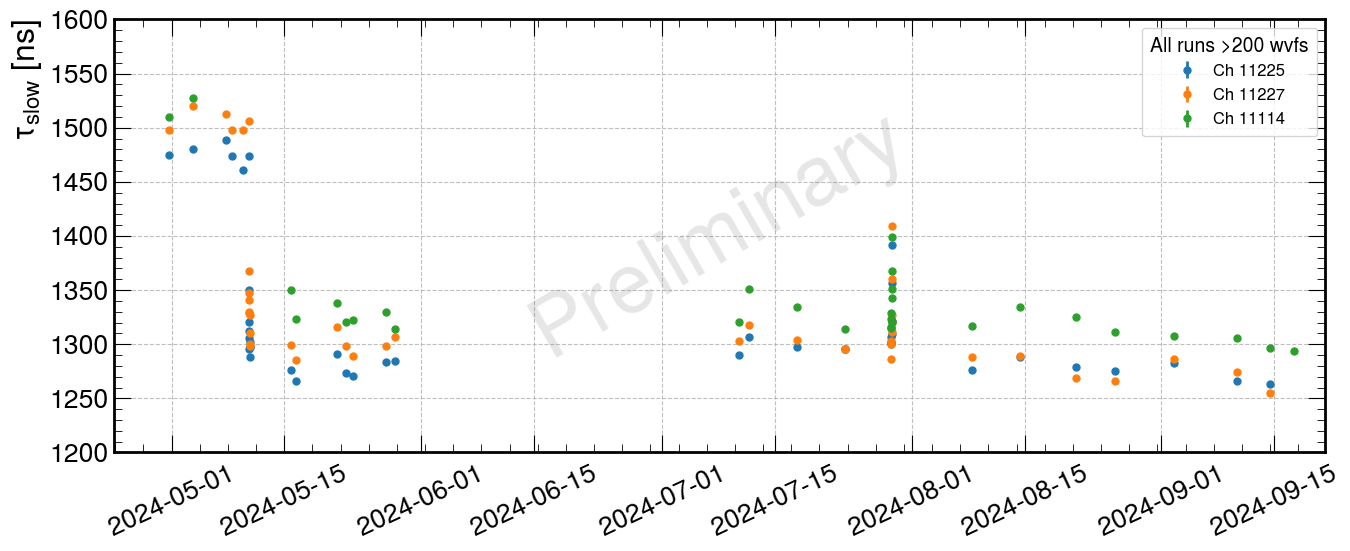

In [133]:
def merged_data(fpurity, fbeam, ch):
    datafixu = read_conv_data(fpurity, ch=ch)
    databeamfixu = read_conv_data(fbeam, ch=ch)
    return np.append(datafixu, databeamfixu)
fpurity = "./results_ultimate2_inter_fixtemplate"
fbeam = "./results_beam_ultimate2_inter_fixtemplate"
merged = {}
ch = 11225
merged[ch] = merged_data(fpurity, fbeam, ch)
ch = 11227
merged[ch] = merged_data(fpurity, fbeam, ch)
ch = 11114
merged[ch] = merged_data(fpurity, fbeam, ch)

def selection_bigger(data):
    _data = data[data['nwvf']>200]
    return _data

xlim=(None,None)
varplot = dict(
    x = 'time',
    y = 'tau_s',
    skipp=None,
    endp=None,
    showHours = False,
    legtitle=f"All runs >200 wvfs",
    legfontsize=12,
    selection=selection_bigger,
)
for k in merged.keys():
    plot_vs_time(merged[k], label=f'Ch {k}', **varplot)
preliminary(plt.gca())
plt.xlim(xlim)
plt.ylim(1200,1600)
plt.savefig(f'tau_vs_time_all_channels.png', dpi=200)


(1100.0, 1600.0)

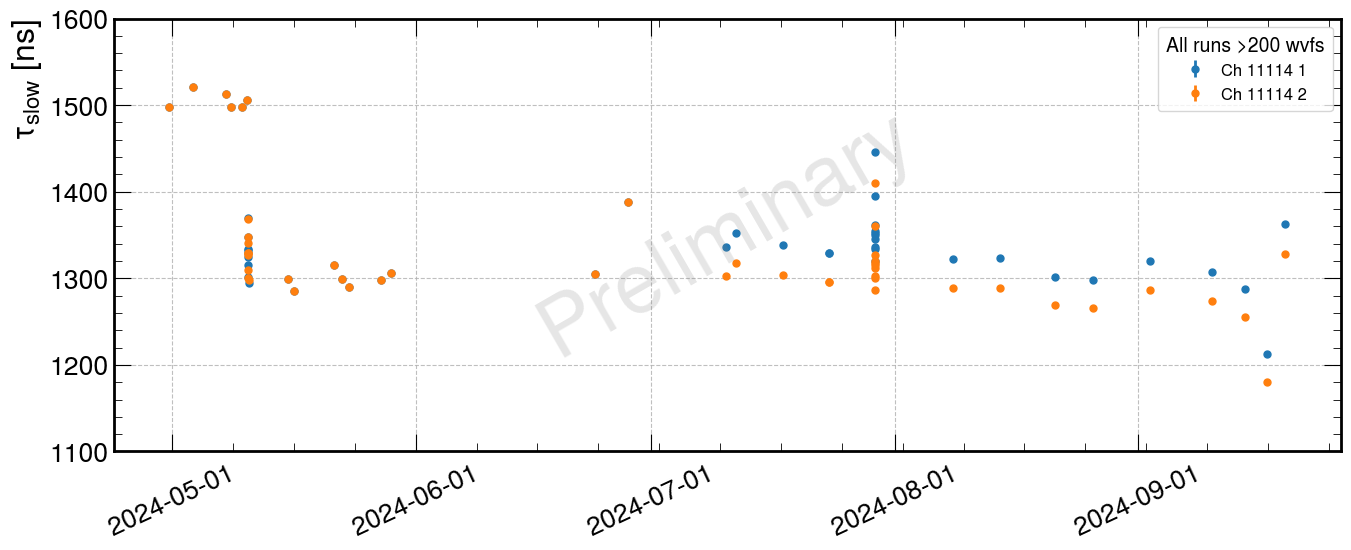

In [131]:

fpurity = "./results_ultimate_inter_fixtemplate/"
fbeam = "./results_beam_ultimate_inter_fixtemplate/"
ch = 11227
normal = merged_data(fpurity, fbeam, ch)
fpurity = "./results_ultimate2_inter_fixtemplate/"
fbeam = "./results_beam_ultimate2_inter_fixtemplate/"
normal2 = merged_data(fpurity, fbeam, ch)

xlim=(None,None)
varplot = dict(
    x = 'time',
    y = 'tau_s',
    skipp=None,
    endp=None,
    showHours = False,
    legtitle=f"All runs >200 wvfs",
    legfontsize=12,
)
plot_vs_time(normal, label=f'Ch {k} 1', **varplot)
plot_vs_time(normal2, label=f'Ch {k} 2', **varplot)
preliminary(plt.gca())
plt.xlim(xlim)
plt.ylim(1100,1600)


In [6]:
import plotly.graph_objects as go
def iplot_vs_time(fig:go.Figure, data=None, x='time', y='tau_s', name='', yaxis_range =[None,None], selection=None):
    
    if selection:
        data = selection(data)
    fig.add_trace(go.Scatter(x=data[x], y=data[y], mode='markers', name=name))


selection = None
fig = go.Figure()
x='run'
y='tau_s'
# iplot_vs_time(fig, x=x, y=y, data=data, name='PDS Only - Dynamic template', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=datafix, name='PDS Only - Fix template 26261', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=datafix2, name='PDS Only - Fix template 29177', selection=selection)
iplot_vs_time(fig, x=x, y=y, data=datafixu, name='PDS Only - Fix template all', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=databeam, name='Beam - Dynamic template ', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=databeamfix, name='Beam - Fix template 26261', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=databeamfix2, name='Beam - Fix template 29177', selection=selection)
iplot_vs_time(fig, x=x, y=y, data=databeamfixu, name='Beam - Fix template all', selection=selection)
# fig.update_layout(yaxis_range=[1200,1700])
fig.show()


In [86]:
ch = 11227
files_plot_resuls = sorted(glob(f"results_ultimate2_inter_fixtemplate/run*/*_ch{ch}.png"))
files_plot_resuls += sorted(glob(f"results_beam_ultimate2_inter_fixtemplate/run*/*_ch{ch}.png"))
nfiles:int = len(files_plot_resuls)
print(len(files_plot_resuls), files_plot_resuls)

48 ['results_ultimate2_inter_fixtemplate/run025171/convfit_data_25171_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run025474/convfit_data_25474_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026078/convfit_data_26078_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026084/convfit_data_26084_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026116/convfit_data_26116_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026141/convfit_data_26141_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026145/convfit_data_26145_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026147/convfit_data_26147_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026149/convfit_data_26149_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026152/convfit_data_26152_template_0_ch11227.png', 'results_ultimate2_inter_fixtemplate/run026154/convfit_data_26154_template_0_ch11227.p

/home/henrique/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



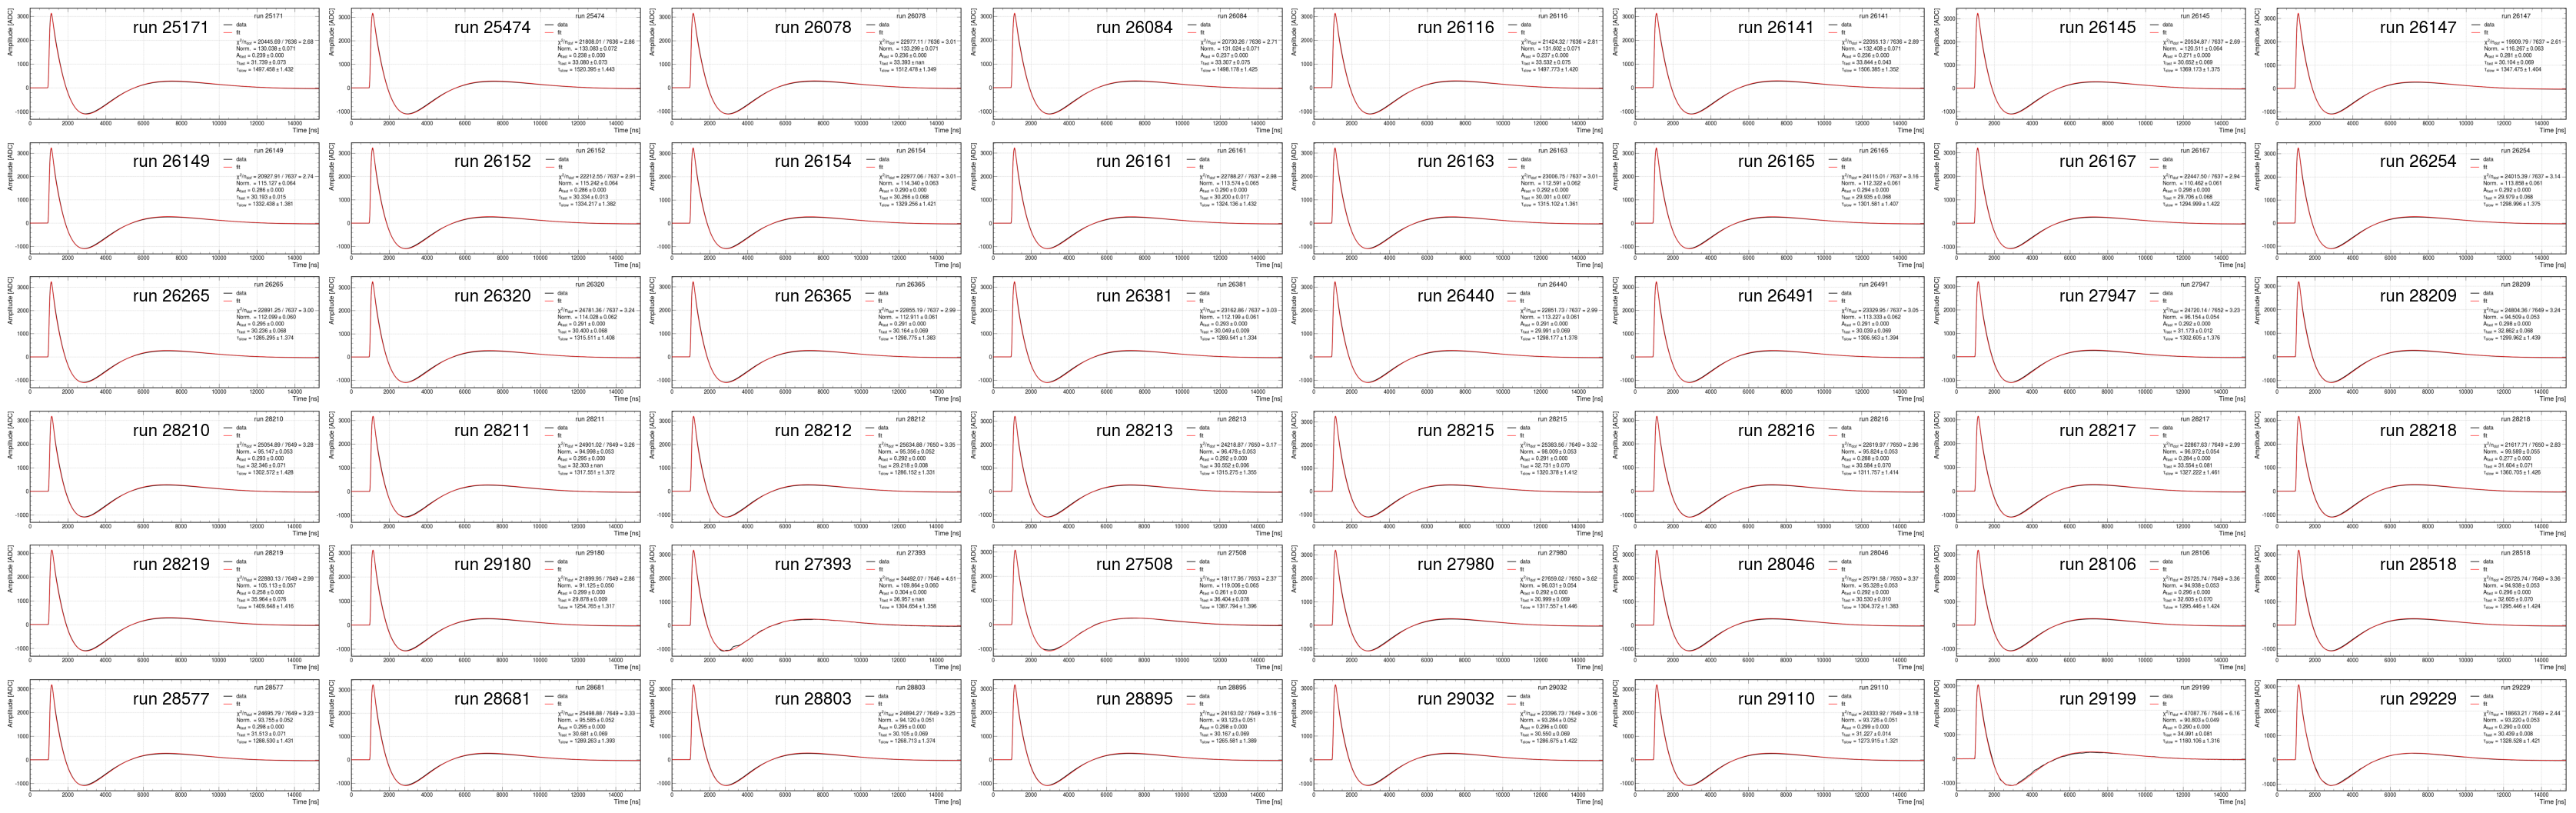

/tmp/ipykernel_3882333/1648060314.py:49: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/tmp/ipykernel_3882333/1648060314.py:50: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [87]:
def close_factors(number):
    ''' 
    find the closest pair of factors for a given number
    '''
    factor1 = 0
    factor2 = number
    while factor1 +1 <= factor2:
        factor1 += 1
        if number % factor1 == 0:
            factor2 = number // factor1
        
    return factor1, factor2
def almost_factors(number):
    '''
    find a pair of factors that are close enough for a number that is close enough
    '''
    while True:
        factor1, factor2 = close_factors(number)
        if 1/2 * factor1 <= factor2: # the fraction in this line can be adjusted to change the threshold aspect ratio
            break
        number += 1
    return factor2, factor1
from mpl_toolkits.axes_grid1 import ImageGrid
import re

fig = plt.figure(figsize=(34, 34.))
nplots = len(files_plot_resuls)
mg, ng = almost_factors(nplots)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(mg,ng),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, files_plot_resuls):
    ax:plt.Axes
    result = plt.imread(im)
    result = result[25:570, 30:1380,:]
    p = re.compile('.*/run0(.+)/convfit')
    m = p.match(im)
    r = f"run {m.group(1)}"
    ax.imshow(result)
    ax.text(0.4,0.8,r, transform=ax.transAxes, fontsize=16)
    ax.axis('off')
if mg*ng != nplots:
    for ax in grid[nplots:]:
        ax.axis('off')

plt.show()
# fig.savefig(f'all_results_ch{ch}.pdf', dpi=300, bbox_inches='tight')
# fig.savefig(f'all_results_ch{ch}.png', dpi=300, bbox_inches='tight')


(1200.0, 1600.0)

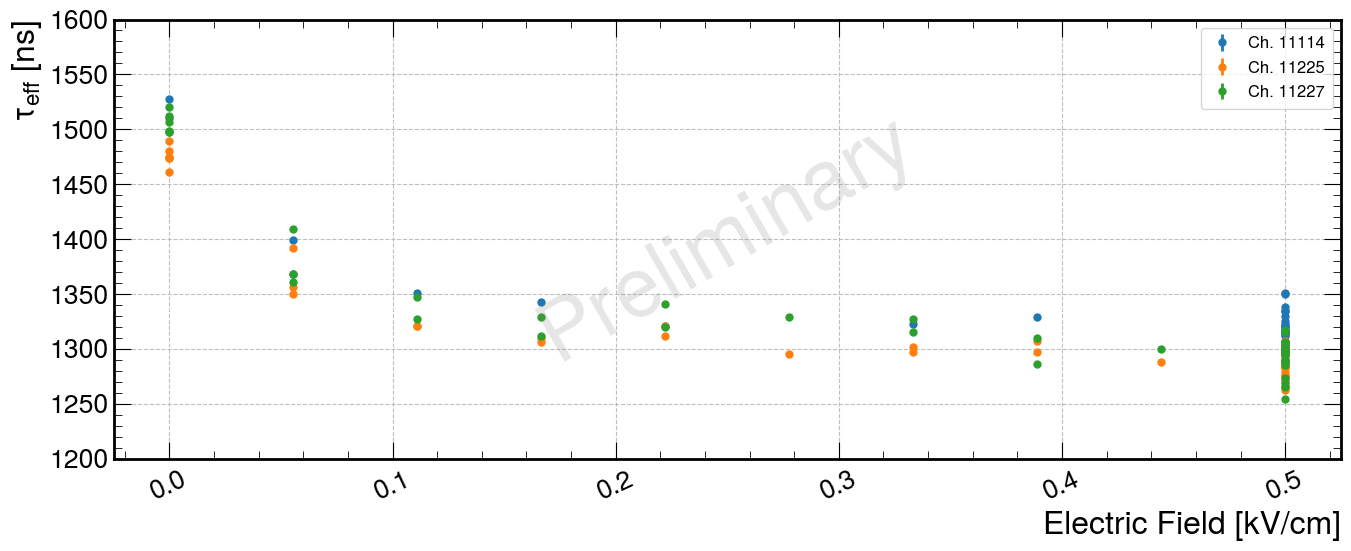

In [129]:
def selection(data):
    _data = data[data['nwvf']>200]
    _data['Efield'] = _data['Efield']/360.
    return _data
varplot = dict(
    x = 'Efield',
    y = 'tau_s',
    skipp=None,
    endp=None,
    isTime = False,
    legtitle=f"",
    legfontsize=12,
    selection=selection,
)
varplot_low_nwvf = varplot.copy()
varplot_low_nwvf.update(dict(
    color='r'
))
channels = [11114, 11225, 11227]
for ch in channels:
    plot_vs_time(merged[ch], label=f'Ch. {ch}', **varplot)
preliminary(plt.gca())
plt.xlim(xlim)
plt.xlabel('Electric Field [kV/cm]')
plt.ylabel(r'$\tau_{eff}$ [ns]')
plt.ylim(1200,1600)
# plt.savefig(f'tau_vs_time_ch{ch}.png', dpi=200)

In [127]:
ch = 11225
dftmp = pl.DataFrame(merged[ch]).drop('time').filter(pl.col('nwvf') > 200)
df = dftmp.with_columns( channel = ch)
ch = 11227
dftmp = pl.DataFrame(merged[ch]).drop('time').filter(pl.col('nwvf') > 200)
dftmp = dftmp.with_columns( channel = ch)
df = pl.concat((df, dftmp))
ch = 11114
dftmp = pl.DataFrame(merged[ch]).drop('time').filter(pl.col('nwvf') > 200)
dftmp = dftmp.with_columns( channel = ch)
df = pl.concat((df, dftmp))
def model_n2(df:pl.DataFrame):
    tau_eff_0 = df.filter(pl.col('Efield')==0)['tau_s'].to_numpy()[0]*1e-3
    er_tau_eff_0 = 0.02
    tau_slow = 1.600
    kq0 = 0.11
    erkq0 = 0.01
    kq = 1/tau_eff_0 - 1/tau_slow
    erkq = kq*(er_tau_eff_0/tau_eff_0)
    n2 = kq/kq0
    ern2 = n2*np.sqrt((erkq/kq)**2 + (erkq0/kq0)**2 )
    return kq, n2, ern2
# kq = 0.11+-0.01 1/ppm 1/us, kq = 0.11 * N2c
kn2, n2c, ern2c = model_n2(df)
print(f"Nitrogen concentration: {n2c:.2f} +/- {ern2c:.2f}")

Nitrogen concentration: 0.48 +/- 0.04


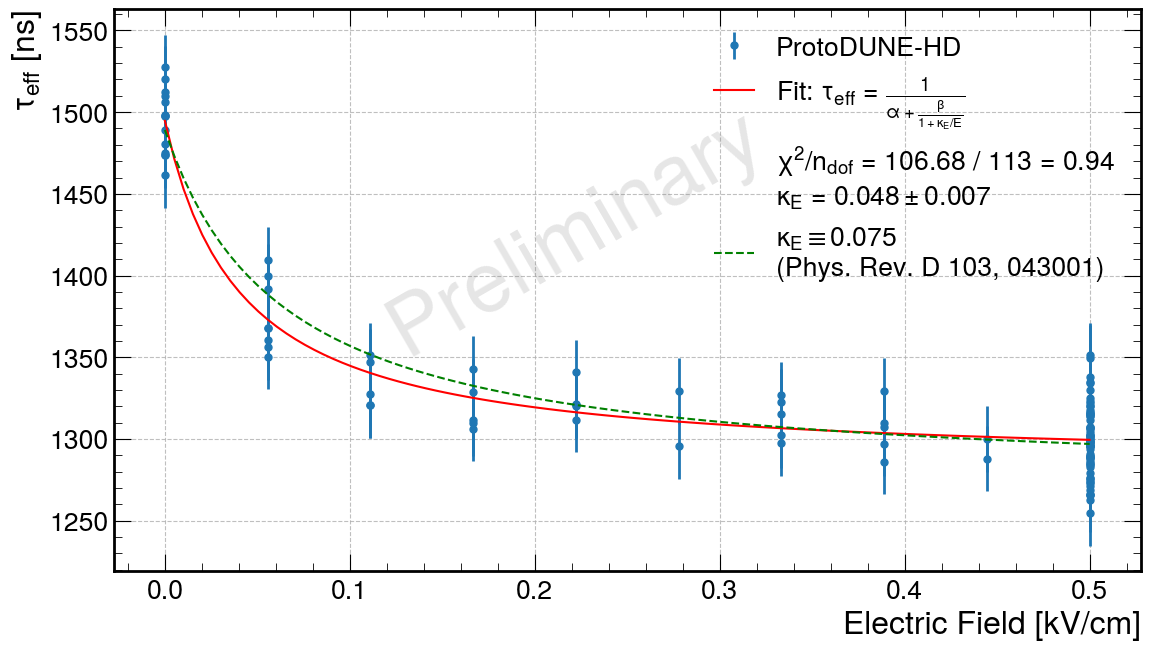

In [130]:
from iminuit import Minuit, cost
from iminuit.util import describe

def model_efield(e, alpha, beta, k):
    with np.errstate(divide='ignore', invalid='ignore'):
        tau = np.divide(1,alpha + beta/(1+k/e), out=np.ones_like(e)/alpha, where=e!=0)
    return tau

ef = df['Efield']/360
tau_s = df['tau_s']

errors = np.ones_like(len(ef))*20.

def dofit(ef, tau_s, errors, fix=False):
    c = cost.LeastSquares(ef, tau_s, errors, model_efield)

    tau_eff_0 = df.filter(pl.col('Efield')==0)['tau_s'].to_numpy()[0]
    alpha = 1/tau_eff_0
    beta = 0.00015
    k = 0.075

    m = Minuit(c,alpha=alpha, beta=beta, k=k)

    m.fixed['k'] = fix

    m.migrad()
    m.migrad()
    m.migrad()

    pars = describe(model_efield)[1:]
    vals = [m.values[p] for p in pars]
    return vals, m
vals, m = dofit(ef, tau_s, errors, False)
ef_fake = np.linspace(ef[0], ef[-1],100)

plt.figure(figsize=(12,7))
plt.errorbar(ef, tau_s, errors, fmt='.', linewidth=2, markersize=10, label='ProtoDUNE-HD')
plt.ylabel(r'$\tau_{eff}$ [ns]')
plt.xlabel(r'Electric Field [kV/cm]')
plt.xlim(-10/360,190/360)

preliminary(plt.gca(),0.45,0.6)

plt.plot(ef_fake,model_efield(ef_fake,*vals),color='r',zorder=100, label=r'Fit: $\tau_{eff}$ = $\frac{1}{\alpha + \frac{\beta}{1+\kappa_E/E}}$')
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.2f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
# for p, v, e in zip(m.parameters, m.values, m.errors):
fit_info.append(f"$\\kappa_E$ = ${m.params['k'].value:.3f} \\pm {m.params['k'].error:.3f}$")
plt.plot([],[], ' ', label='\n'.join(fit_info))

vals_ettore, me = dofit(ef, tau_s, errors, True)
plt.plot(ef_fake,model_efield(ef_fake,*vals_ettore), '--g',zorder=200, label=r"$\kappa_E \equiv 0.075$" "\n" "(Phys. Rev. D 103, 043001)")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,0,1,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig('tau_vs_efield_fit.png', dpi=200)

